In [402]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [403]:
from sklearn.feature_selection import SelectKBest

In [404]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## Custom Functions

In [424]:
def data_viz(df, columns, target=None, plot_type='bar'):
    if plot_type == 'hist':
        subplots_in_a_row = 4
    else:
        subplots_in_a_row = 2
    
    number_of_columns = len(columns)
    rows_required, remainder = divmod(number_of_columns, subplots_in_a_row)
    if remainder != 0:
        rows_required += 1
    fig, axes = plt.subplots(rows_required, subplots_in_a_row, figsize=(22, 6*rows_required))
    
    if plot_type == 'hist':
        for col, subplot in zip(columns, axes.flatten()):
            sns.distplot(df[col], ax=subplot)
    elif plot_type == 'bar':
        for col, subplot in zip(columns, axes.flatten()):
            sns.countplot(df[col], ax=subplot)
    elif plot_type == 'scatter':
        for col, subplot in zip(columns, axes.flatten()):
            sns.scatterplot(x=col,y=target, data=df, ax=subplot)
    elif plot_type == 'cross_tab':
        for col, subplot in zip(columns, axes.flatten()):
            ct = pd.crosstab(df[col], df[target])
            ct.plot.bar(ax=subplot)
    else:
        for col, subplot in zip(columns, axes.flatten()):
            sns.boxplot(df[col], ax=subplot)

In [406]:
def handle_outlier(df, columns):
    for col in columns:
        q1, q3 = np.percentile(df[col], [25,75])
        iqr = q3-q1
        lower_bound = iqr - (1.5*iqr)
        upper_bound = iqr + (1.5*iqr)
        df[col] = np.where(df[col]<lower_bound,lower_bound, np.where(df[col]>upper_bound, upper_bound, df[col]))

In [407]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [408]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [409]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [410]:
train['is_train'] = 1
test['is_train'] = 0
test['Loan_Status'] = 'N'

full = train.append(test)

In [411]:
full.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,is_train
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,1


In [413]:
full.isna().mean()*100#(full.isna().sum()/full.shape[0])*100

Loan_ID              0.000000
Gender               2.446483
Married              0.305810
Dependents           2.548420
Education            0.000000
Self_Employed        5.606524
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           2.752294
Loan_Amount_Term     2.038736
Credit_History       8.053007
Property_Area        0.000000
Loan_Status          0.000000
is_train             0.000000
dtype: float64

In [428]:
no_crd_hst = full[full['Credit_History'].isna()]

In [433]:
no_crd_hst['Loan_ID'].unique()
# full['LoanAmount'].fillna(full['LoanAmount'].median(), inplace=True)

array(['LP001034', 'LP001052', 'LP001091', 'LP001123', 'LP001264',
       'LP001273', 'LP001280', 'LP001326', 'LP001405', 'LP001443',
       'LP001465', 'LP001469', 'LP001541', 'LP001634', 'LP001643',
       'LP001671', 'LP001734', 'LP001786', 'LP001788', 'LP001864',
       'LP001865', 'LP001908', 'LP001998', 'LP002008', 'LP002036',
       'LP002043', 'LP002055', 'LP002137', 'LP002178', 'LP002223',
       'LP002263', 'LP002272', 'LP002319', 'LP002424', 'LP002444',
       'LP002447', 'LP002478', 'LP002522', 'LP002560', 'LP002562',
       'LP002588', 'LP002618', 'LP002624', 'LP002717', 'LP002729',
       'LP002757', 'LP002794', 'LP002833', 'LP002898', 'LP002949',
       'LP001035', 'LP001083', 'LP001163', 'LP001174', 'LP001232',
       'LP001475', 'LP001527', 'LP001558', 'LP001601', 'LP001771',
       'LP001791', 'LP001921', 'LP002009', 'LP002017', 'LP002046',
       'LP002111', 'LP002212', 'LP002415', 'LP002425', 'LP002441',
       'LP002566', 'LP002581', 'LP002712', 'LP002816', 'LP0028

## EDA

In [417]:
numeric_columns = full.select_dtypes(exclude = ['object']).columns.tolist()
numeric_columns.remove('Credit_History')
numeric_columns.remove('Loan_Amount_Term')
numeric_columns.remove('is_train')
categoric_columns = full.select_dtypes(include=['object']).columns.tolist()
categoric_columns.remove('Loan_ID')
categoric_columns.append('Credit_History')
categoric_columns.append('Loan_Amount_Term')

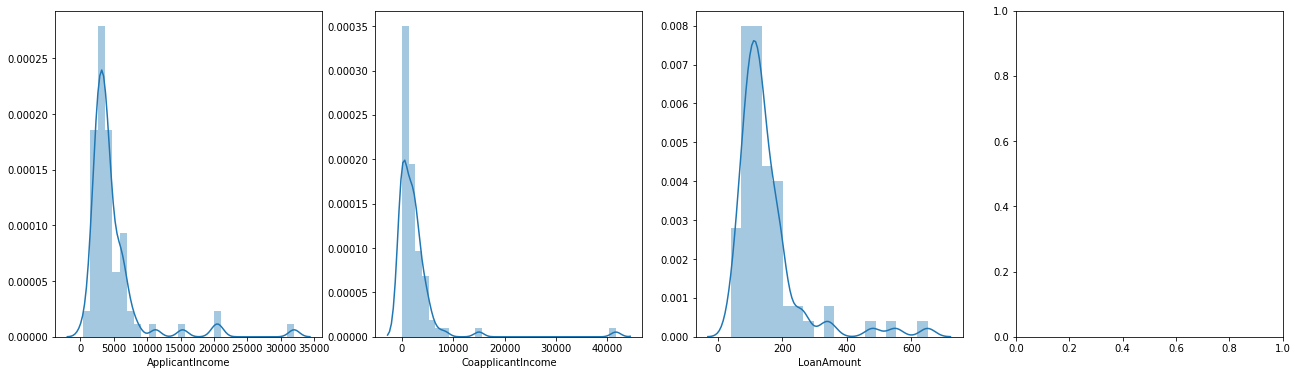

In [415]:
data_viz(no_crd_hst, numeric_columns, plot_type='hist')

ValueError: min() arg is an empty sequence

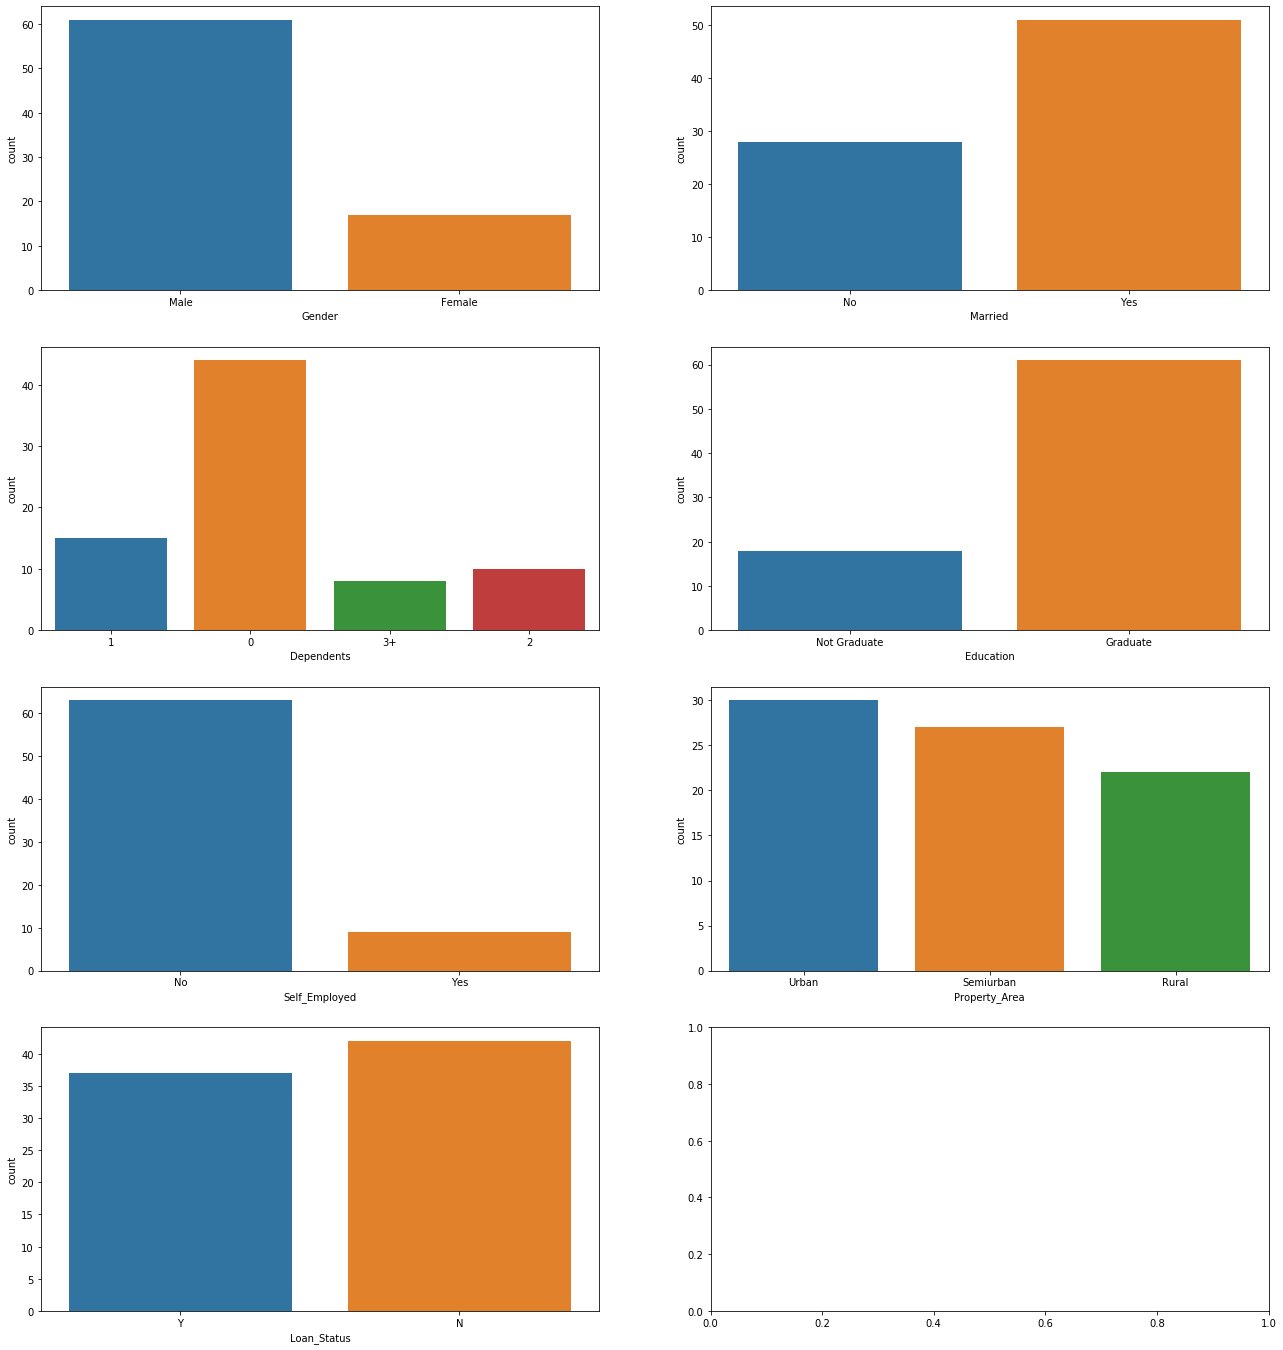

In [423]:
data_viz(no_crd_hst, categoric_columns, plot_type='bar')

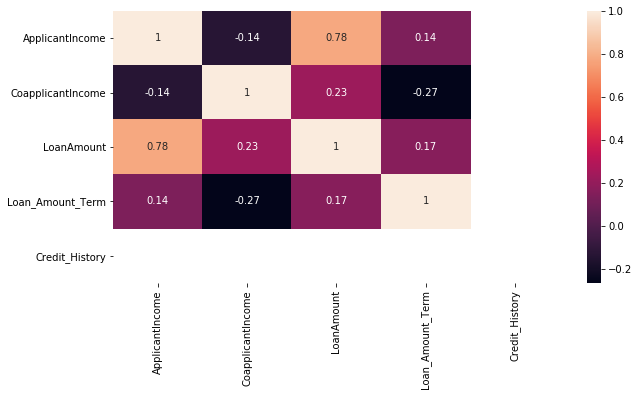

In [425]:
plt.subplots(figsize = (10,5))
sns.heatmap(no_crd_hst.drop(['is_train'], axis=1).corr(), annot=True)

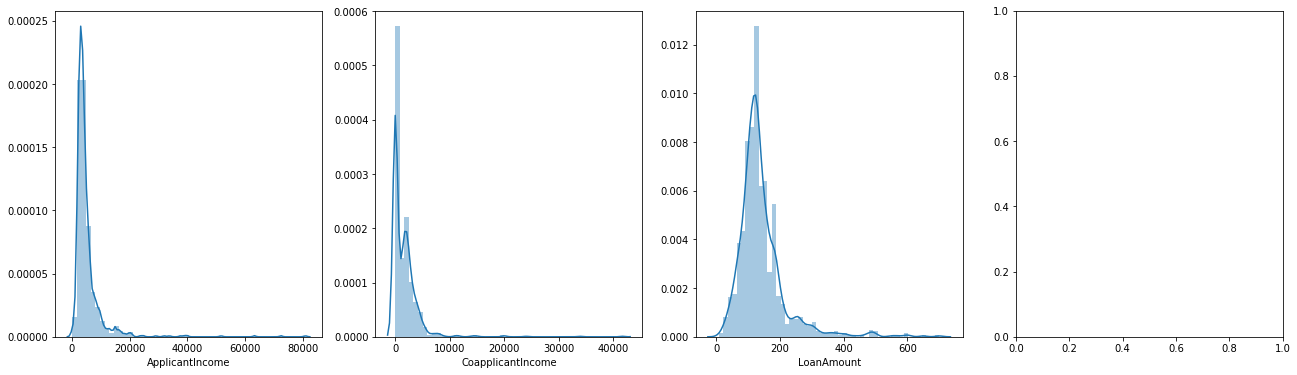

In [379]:
data_viz(full, numeric_columns, plot_type='hist')

In [380]:
# data_viz(full, categoric_columns, plot_type='bar')

In [381]:
q1, q3=np.percentile(full['LoanAmount'], [25,75])
print(q1)
print(q3)

101.0
160.0


In [382]:
# data_viz(full, numeric_columns[0:2], target='LoanAmount',plot_type='scatter')

In [383]:
numeric_columns

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

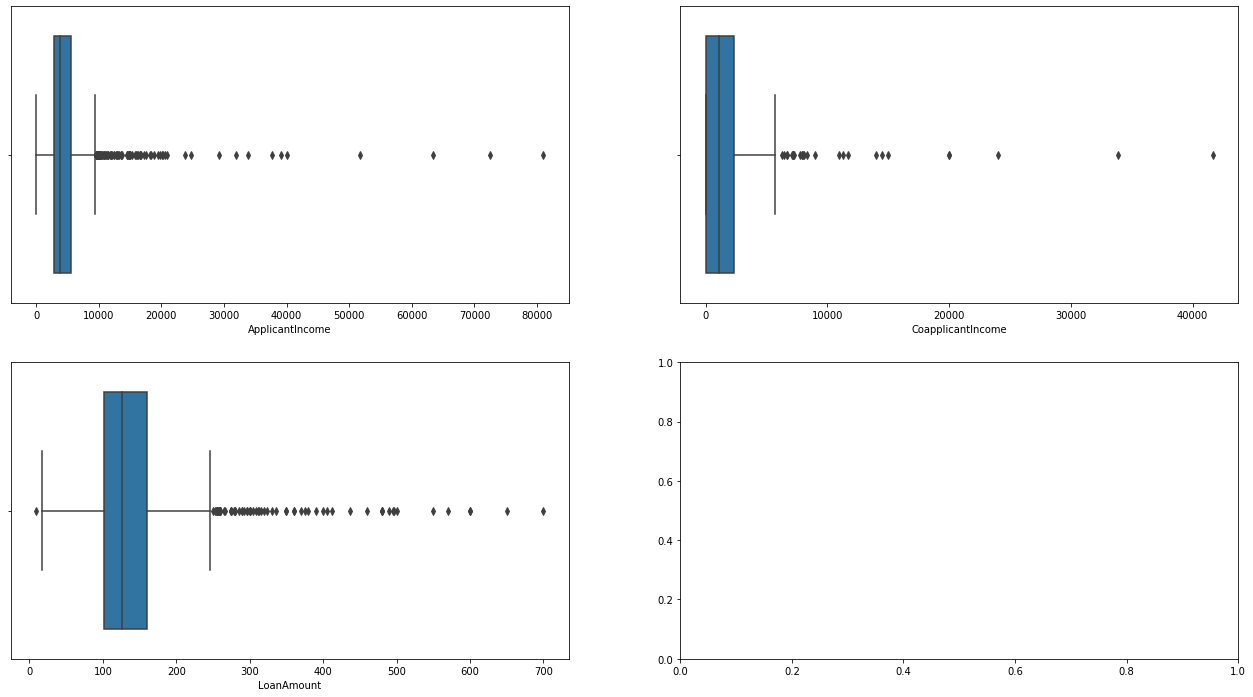

In [384]:
data_viz(full, numeric_columns, plot_type='box')

In [385]:
handle_outlier(full, numeric_columns)

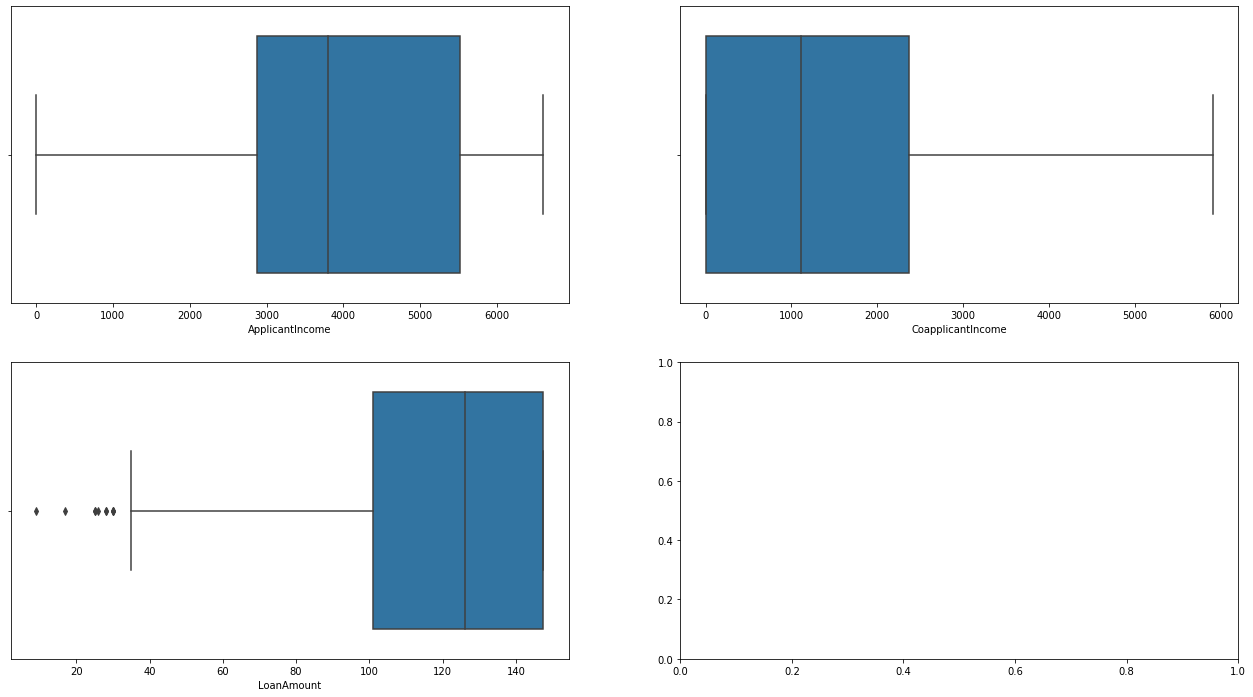

In [386]:
data_viz(full, numeric_columns, plot_type='box')

## Feature Engineering

In [387]:
# full['Total_Income'] = full['ApplicantIncome'] + full['CoapplicantIncome']

In [388]:
full['Gender'].fillna(full['Gender'].mode()[0], inplace=True)
full['Married'].fillna(full['Married'].mode()[0], inplace=True)
full['Dependents'].fillna(full['Dependents'].mode()[0], inplace=True)
full['Self_Employed'].fillna(full['Self_Employed'].mode()[0], inplace=True)
full['LoanAmount'].fillna(full['LoanAmount'].mean(), inplace=True)
full['Loan_Amount_Term'].fillna(full['Loan_Amount_Term'].mean(), inplace=True)
full['Credit_History'].fillna(0.0, inplace=True)

In [389]:
# (full.isna().sum()/full.shape[0])*100
# full['LoanAmount'] = full['LoanAmount'].apply(lambda x: round(x*1000))

In [390]:
full.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,is_train
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,126.0,360.0,1.0,Urban,Y,1
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y,1
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y,1


In [391]:
# data_viz(full, categoric_columns, target='Loan_Status', plot_type='cross_tab')

In [392]:
full.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'is_train'],
      dtype='object')

In [393]:
# full['Amount_Range'] = (full['LoanAmount']/full['Total_Income'])

In [394]:
lableEncoder = LabelEncoder()
full['Loan_Status']=lableEncoder.fit_transform(full['Loan_Status'])

In [395]:
full['Dependents']=lableEncoder.fit_transform(full['Dependents'])

In [396]:
full['Education']=lableEncoder.fit_transform(full['Education'])
full['Self_Employed']=lableEncoder.fit_transform(full['Self_Employed'])
full['Property_Area']=lableEncoder.fit_transform(full['Property_Area'])
full['Gender']=lableEncoder.fit_transform(full['Gender'])
full['Married']=lableEncoder.fit_transform(full['Married'])

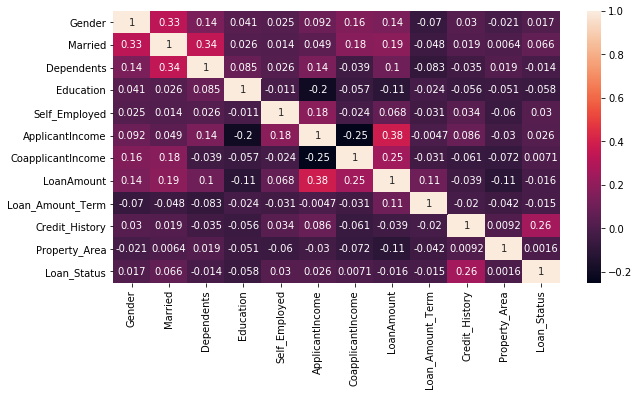

In [397]:
plt.subplots(figsize = (10,5))
sns.heatmap(full.drop(['is_train'], axis=1).corr(), annot=True)

In [398]:
full.head(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,is_train
0,LP001002,1,0,0,0,0,5849.0,0.0,126.0,360.0,1.0,2,1,1


In [399]:
# drop_columns = ['Gender','Dependents', 'CoapplicantIncome','Loan_Amount_Term','Property_Area']

In [400]:
# full.drop(drop_columns, axis=1, inplace=True)

In [401]:
full.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,is_train
0,LP001002,1,0,0,0,0,5849.0,0.0,126.0,360.0,1.0,2,1,1
1,LP001003,1,1,1,0,0,4583.0,1508.0,128.0,360.0,1.0,0,0,1


In [341]:
# full['Education_By_Area_History'] = full.groupby(['Credit_History', 'Property_Area'])['Education'].transform('sum')

In [342]:
# full['Min_Total_Income_By_History'] = full.groupby(['Credit_History'])['Total_Income'].transform('min')
# full['Max_Total_Income_By_History'] = full.groupby(['Credit_History'])['Total_Income'].transform('max')
# full['Mean_Total_Income_By_History'] = full.groupby(['Credit_History'])['Total_Income'].transform('mean')
# full['Std_Total_Income_By_History'] = full.groupby(['Credit_History'])['Total_Income'].transform('std')

# full['Gender_By_History'] = full.groupby(['Credit_History'])['Gender'].transform('sum')
# full['Married_By_History'] = full.groupby(['Credit_History'])['Married'].transform('sum')
# full['Education_By_History'] = full.groupby(['Credit_History'])['Education'].transform('sum')
# full['Self_Emp_By_History'] = full.groupby(['Credit_History'])['Self_Employed'].transform('sum')
# full['History_By_History'] = full.groupby(['Credit_History'])['Credit_History'].transform('sum')

In [343]:
# full['Min_Total_Income_By_Area'] = full.groupby(['Property_Area'])['Total_Income'].transform('min')
# full['Max_Total_Income_By_Area'] = full.groupby(['Property_Area'])['Total_Income'].transform('max')
# full['Mean_Total_Income_By_Area'] = full.groupby(['Property_Area'])['Total_Income'].transform('mean')
# full['Std_Total_Income_By_Area'] = full.groupby(['Property_Area'])['Total_Income'].transform('std')

# full['Min_Loan_By_Area'] = full.groupby(['Property_Area'])['LoanAmount'].transform('min')
# full['Max_Loan_By_Area'] = full.groupby(['Property_Area'])['LoanAmount'].transform('max')
# full['Mean_Loan_By_Area'] = full.groupby(['Property_Area'])['LoanAmount'].transform('mean')
# full['Std_Loan_By_Area'] = full.groupby(['Property_Area'])['LoanAmount'].transform('std')

# full['Gender_By_Area'] = full.groupby(['Property_Area'])['Gender'].transform('sum')
# full['Married_By_Area'] = full.groupby(['Property_Area'])['Married'].transform('sum')
# full['Education_By_Area'] = full.groupby(['Property_Area'])['Education'].transform('sum')
# full['Self_Emp_By_Area'] = full.groupby(['Property_Area'])['Self_Employed'].transform('sum')
# full['History_By_Area'] = full.groupby(['Property_Area'])['Credit_History'].transform('sum')

## Train Test Split

In [344]:
train = full[full['is_train']==1]
test = full[full['is_train']==0]

y = train['Loan_Status']
Load_IDs = test['Loan_ID']

drop_columns = ['Loan_ID', 'is_train', 'Loan_Status']
train.drop(drop_columns, axis=1, inplace=True)
test.drop(drop_columns, axis=1, inplace=True)


In [345]:
X_train, X_val, y_train, y_val = train_test_split(train[['Credit_History', 'Married']],y,random_state=15, stratify=y)

In [346]:
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
1    0.686957
0    0.313043
Name: Loan_Status, dtype: float64
1    0.688312
0    0.311688
Name: Loan_Status, dtype: float64


## Models Creation

In [347]:
xgb_model = XGBClassifier(random_state=15)

In [348]:
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

In [349]:
space = {
    'n_estimators': hp.choice('n_estimators', [100, 500, 1000, 1500, 2000]),
    'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'max_depth': hp.choice('max_depth', [1,10,25,50]),
    'min_samples_split': hp.choice('min_samples_split', [1]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1])
}

In [350]:
def objective(space):
    best_model = XGBClassifier(n_estimators= space['n_estimators'],criterion= space['criterion'],max_features= space['max_features'],max_depth= space['max_depth'], min_samples_split =space['min_samples_split'], min_samples_leaf= space['min_samples_leaf'])
    best_model.fit(X_train, y_train) 
    predictions = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return {'loss':-accuracy, 'status':STATUS_OK}

In [351]:
trials = Trials()
best_params = fmin(fn= objective, space=space, algo=tpe.suggest, trials=trials, max_evals=100)
best_params

100%|██████████| 100/100 [00:07<00:00, 13.59trial/s, best loss: -0.7857142857142857]


{'criterion': 0,
 'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 0,
 'min_samples_split': 0,
 'n_estimators': 0}

In [352]:
req_estimators = [100, 500, 1000, 1500, 2000]
req_criterion = {0:'entropy', 1:'gini'}
req_features = ['auto', 'sqrt', 'log2', None]
req_depth = [10,25,50]
req_sample_split = [1,2,3,5]
req_sample_leaf = [1,2]

In [353]:
best_model = XGBClassifier(n_estimators= req_estimators[best_params['n_estimators']],
                           criterion= req_criterion[best_params['criterion']],
                           max_features= req_features[best_params['max_features']],
                           max_depth= req_depth[best_params['max_depth']],
                           min_samples_split =req_sample_split[best_params['min_samples_split']], 
                           min_samples_leaf= req_sample_leaf[best_params['min_samples_leaf']],
                           random_state=15)

IndexError: list index out of range

In [ ]:
best_model.fit(X_train, y_train)

In [ ]:
y_predictions_xgb = best_model.predict(test[['Credit_History', 'Married']])

In [ ]:
output = pd.DataFrame({'Loan_ID':Load_IDs,'Loan_Status':y_predictions_xgb})

In [ ]:
output['Loan_Status'] = output['Loan_Status'].map({1:'Y', 0:'N'})

In [ ]:
output['Loan_Status'].value_counts()

In [ ]:
output.to_csv('submission.csv', index=False)